## Installation

When working within Google Colab, additional packages is necessary to take full advantage of the library. To install these, execute the following command:

In [1]:
%pip install mrcfile tensorflow-graphics umap-learn wandb ipyvolume -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.2/688.2 kB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%pip install tensorflow_similarity -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.4/230.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


To begin using the dataset with our codebase in Colab, you first need to download it to your environment. In this tutorial, we'll proceed under the assumption that the dataset is stored on Google Drive. The following steps will guide you through the process of transferring the dataset from Google Drive to the local disk space provided by Colab:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DRIVE = "/content/drive/MyDrive/protein-reconstruction/data/data/beta-gal_synthetic/"
DATASET_PATH = ""

In [5]:
# The path pointed to cryoforum packages
ROOT_DIR = '/content/drive/MyDrive/protein-reconstruction/'

In [6]:
!cp {DRIVE}X_beta.npy .
!cp {DRIVE}y_beta.npy .
!cp {DRIVE}beta_ctf_q2.mrcs .
!cp {DRIVE}beta_ctf_q2.star .
!cp {DRIVE}beta_noisy.mrcs .
!cp {DRIVE}indices.npz .

> If you're executing this on a local machine, you should directly specify the path to where your dataset resides by setting the `DATASET_PATH`. For instance, if your dataset is located in the directory `/home/username/cryoforum/data/beta-gal_synthetic/`, you would assign this path to the variable like so: `DATASET_PATH = "/home/username/cryoforum/data/beta-gal_synthetic/"`.

## Generate the datasets

To illustrate how our framework can be applied to symmetric proteins, we utilized the beta-galactosidase dataset, which exhibits D2 symmetry. Accounting for symmetry is critical; otherwise, two projections might appear to be identical even though they stem from distinct orientations. To circumvent this, our framework restricts the orientation space during training. For proteins with D2 symmetry, we confine the orientation parameters to \( Z \in [0, 2\pi] \), \( Y \in [0, \frac{\pi}{2}] \), and \( Z' \in [0, \pi] \) (adopting the Z-Y-Z rotation convention common in Cryo-EM). This restriction guarantees a unique correspondence between each particle and its orientation. For a more comprehensive understanding of how symmetry is handled, please refer to the documentation [here](https://scipion-em.github.io/docs/release-3.0.0/docs/developer/symmetries/symmetries.html).

Additional package is required for the generation of angles that respect symmetry constraints:

In [ ]:
%pip install h5py ConfigArgParse -qq

We will begin by copying the `generator.py` script, which is designed to uniformly generate angles while adhering to the symmetry constraints imposed by the dataset:

In [ ]:
!cp {DRIVE}generator.py .
!cp {DRIVE}beta_volume.mrc .
!cp {DRIVE}protein.config .
!cp {DRIVE}template.star .

In [ ]:
import mrcfile
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import h5py

sys.path.append(ROOT_DIR)

from cryoem.utils_ascep import visualise_images, Starfile
from cryoem.helpers import projections_preprocessing
from cryoem.plots import plot_angles_histogram, plot_quaternions_histogram

> If your work involves proteins with different symmetries, you are encouraged to adjust the angular coverage parameters accordingly in your experiments.

In [ ]:
%env ROOT_DIR=$ROOT_DIR

env: ROOT_DIR=/content/drive/MyDrive/protein-reconstruction/


In [ ]:
%%bash

export PYTHONPATH=$ROOT_DIR:$PYTHONPATH

python generator.py --input-file beta_volume.mrc --output-file beta_uniformS2.h5 -ang-gen uniform_S2 -num 5000 -shift 0.0 -shift 0.0 -shift 0.0 -cov 2.0 -cov 0.5 -cov 1

----------
Command Line Args:   --input-file beta_volume.mrc --output-file beta_uniformS2.h5 -ang-gen uniform_S2 -num 5000 -shift 0.0 -shift 0.0 -shift 0.0 -cov 2.0 -cov 0.5 -cov 1

----------
* Generating the dataset *
(5000, 3)
Protein:         beta_volume
Input filename:  beta_volume.mrc
Output filename: beta_uniformS2.h5
Angles (#):      (5000, 3)

**********


2023-11-04 04:26:01.988078: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-04 04:26:01.988142: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-04 04:26:01.988175: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-04 04:26:03.310172: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-04 04:26:10.182449: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [ ]:
# half coverage (AngCoverage=0.5)
projections_filename = "beta_uniformS2.h5"

# load structures
data_full_5k_uniform = h5py.File(projections_filename, 'r')
angles = np.array(data_full_5k_uniform['Angles'], dtype=np.float32)

print(f"{angles.shape[0]} sets of {angles.shape[1]} ground truth angles of corresponding projection images")

5000 sets of 3 ground truth angles of corresponding projection images


We can depict the distribution of the generated angles using the following visualization technique:

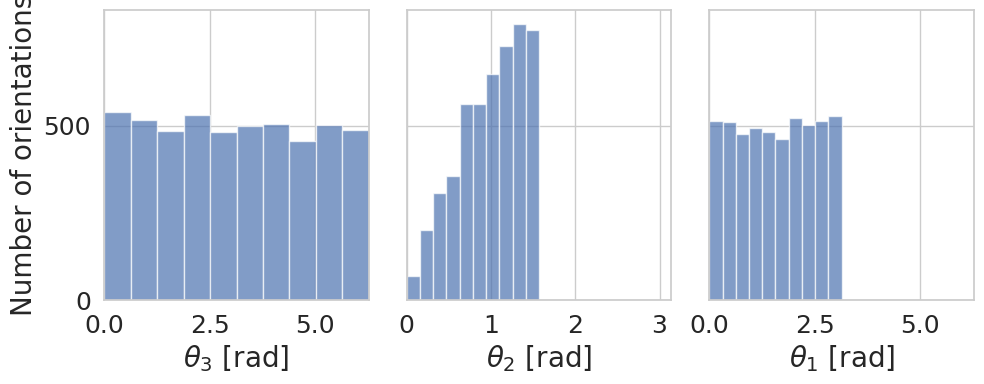

In [ ]:
plot_angles_histogram([angles], plot_settings=dict(figsize=(10, 4)))

We can generate a template STAR file using `RELION` that matches the number of angles (5000) generated by the above code. This STAR file can be used for subsequent processes:

```python
relion_project --i beta_volume.mrc --nr_uniform 5000 --angpix 2.49
relion_star_handler --i proj.star --add_column rlnDefocusU --add_column_value 21580.0
relion_star_handler --i out.star --add_column rlnDefocusV --add_column_value 21580.0
relion_star_handler --i out.star --add_column rlnDefocusAngle --add_column_value 0.0
```

Make sure to adjust the defocus values (`21580.0`) and the defocus angle (`0.0`) to suit the specifics of your experiment.

We will now load the metadata from the template into a Pandas `DataFrame` and transform the Euler angles from degrees to radians for computational purposes:

In [ ]:
projections_filename = DATASET_PATH+"template.star"
s = Starfile.load(projections_filename)
df = s.df

We'll update the Euler angles in our `DataFrame` with the ones we've generated, ensuring they are properly integrated into the metadata structure:

In [ ]:
df['_rlnAngleRot'] = angles[:,2]/(2*np.pi)*360
df['_rlnAngleTilt'] = angles[:,1]/(2*np.pi)*360
df['_rlnAnglePsi'] = angles[:,0]/(2*np.pi)*360
df['_rlnAngleRot'] = df['_rlnAngleRot'].astype(str)
df['_rlnAngleTilt'] = df['_rlnAngleTilt'].astype(str)
df['_rlnAnglePsi'] = df['_rlnAnglePsi'].astype(str)

In [ ]:
df.head()

,_rlnAnglePsi,_rlnAngleRot,_rlnAngleTilt,_rlnImageName,_rlnOriginX,_rlnOriginY,_rlnDefocusU,_rlnDefocusV,_rlnDefocusAngle
0,0.0,0.0,0.0,000001@70S_ctf_128.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
1,264.58963,26.303627,57.95592,000002@70S_ctf_128.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
2,20.233032,168.8814,80.64346,000003@70S_ctf_128.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
3,344.41806,95.52359,86.50975,000004@70S_ctf_128.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
4,35.053204,91.589035,81.385124,000005@70S_ctf_128.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000


In [ ]:
s.write('beta.star')

We can apply the Contrast Transfer Function (CTF) to each image in the Fourier domain using the following `RELION` command:

```python
relion_project --i beta_volume.mrc --ang beta_ctf.star --ctf --o beta_ctf_q2 --angpix 2.49
```

Ensure that the input volume (`beta_volume.mrc`), the angles STAR file (`beta_ctf.star`), and the output (`beta_ctf_q2`) are specified correctly, and the pixel size (`angpix`) is set according to your dataset's requirements.

In [ ]:
s = Starfile.load(DATASET_PATH+'beta_ctf_q2.star')
df = s.df

theta1 = df['_rlnAngleRot'].astype(float).values/360*2*np.pi
theta2 = df['_rlnAngleTilt'].astype(float).values/360*2*np.pi
theta3 = df['_rlnAnglePsi'].astype(float).values/360*2*np.pi
shift_x = df['_rlnOriginX'].astype(float).values
shift_y = df['_rlnOriginY'].astype(float).values

angles_true = np.stack((theta3, theta2, theta1), axis=-1)

Load the projection data into the working environment:

In [ ]:
mrc = mrcfile.open(DATASET_PATH+'beta_ctf_q2.mrcs')
proj = mrc.data

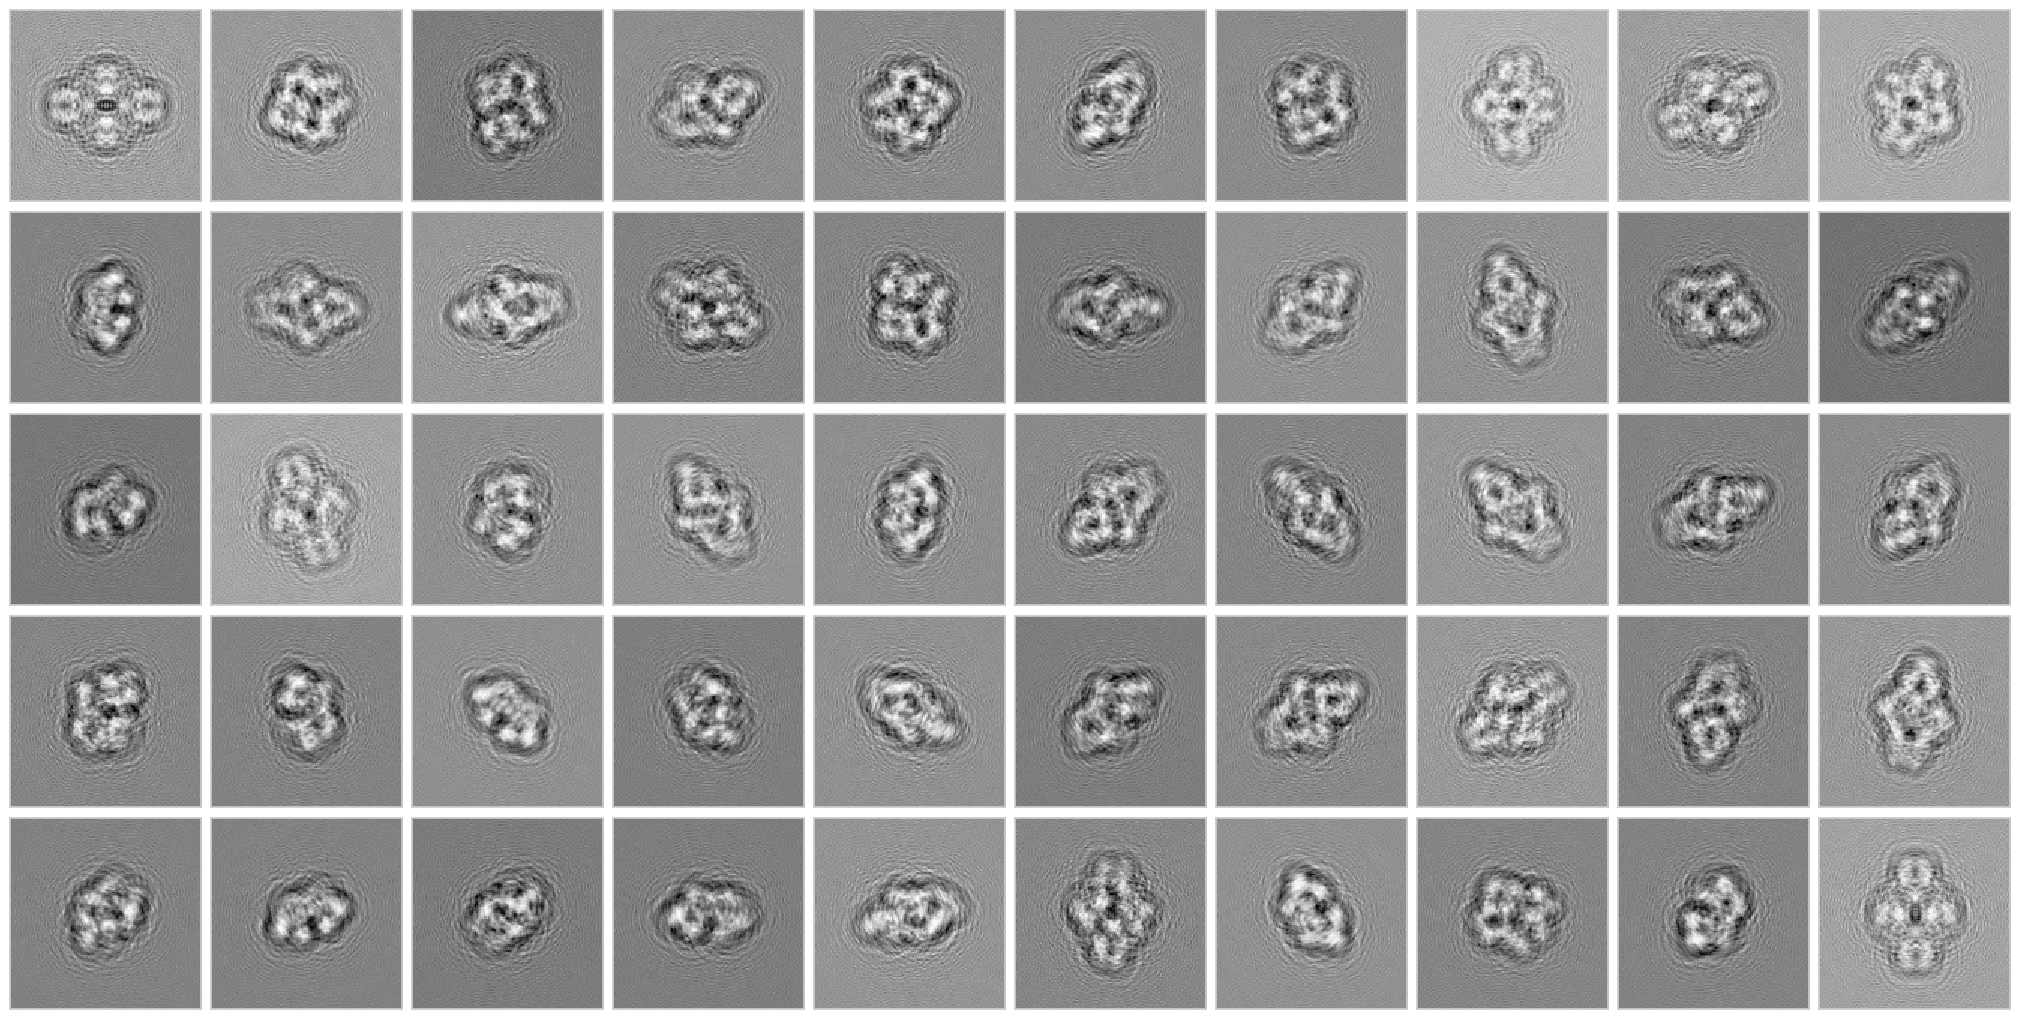

In [ ]:
visualise_images(proj, 50 , 10, False)

Complete your data preprocessing by applying random translations to the projections on the `x` and `y` axes. Then, to simulate real experimental conditions, superimpose i.i.d. Gaussian noise onto the clean projection data. This step enhances the realism of your dataset by reflecting the variations and uncertainties present in actual experimental data:

In [ ]:
snr = 0.1
noise_var = proj.var()/snr
noise_var

1.872154176235199

Here, the Gaussian distribution is used to model potential residual after particle picking:

In [ ]:
settings = dict(
    noise={"variance":noise_var},
    shift={"mu":0,
           "sigma":0},
    channels="gray"
)

In [ ]:
X, y = projections_preprocessing(proj, angles_true, settings=settings)

{'noise': {'variance': 1.872154176235199}, 'shift': {'mu': 0, 'sigma': 0}, 'channels': 'gray'}
Image shape: (128, 128)
Data Type: float32
***
Mean: -0.000 | Std: 1.435
Min:  -8.078 | Max: 9.910
Mean: 0.000 | Std: 1.000
Min:  -5.629 | Max: 6.905


Adjust the magnitude of the shifts and the signal-to-noise ratio (SNR) to experiment with various configurations. After applying these changes, visualize the resulting images to assess the impact of different noise and shift levels on the projections:

In [ ]:
visualise_images(X.squeeze(), 50 , 10, False)

Output hidden; open in https://colab.research.google.com to view.

After ensuring the synthetic data meets our expectation, we can proceed to save it to disk. It is important to also save a file, named `indices.npz`, which contains the indices used for training and validation splits. This step is crucial for ensuring the reproducibility of our experiments:

In [ ]:
np.save('X_beta.npy', X)
np.save('y_beta.npy', y)

In [ ]:
DATA_PATH = "/content/drive/MyDrive/protein-reconstruction/data/"

In [ ]:
!cp X_beta.npy {DATA_PATH}
!cp X_beta.npy {DATA_PATH}
#!cp indices.npz {DATA_PATH}

To concentrate solely on the precision of orientation recovery, let's save the noisy images without shifts in the following manner:

In [ ]:
mrc = mrcfile.open('beta_ctf_q2.mrcs')
proj = mrc.data

In [ ]:
snr = 0.1
noise_var = proj.var()/snr

settings = dict(
    noise={"variance":noise_var},
    shift={"mu":0,
           "sigma":0},
    channels="gray"
)

X, y = projections_preprocessing(proj, y, settings=settings)

visualise_images(X.squeeze(), 50 , 10, False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
X = X.squeeze()
X.shape

(5000, 128, 128)

In [ ]:
with mrcfile.new('beta_noisy.mrcs', overwrite=True) as mrc:
    mrc.set_data(X)

In [ ]:
!cp beta_noisy.mrcs {DATA_PATH}

## Learning the Orientation Recovery Function

Next, we'll import the necessary packages into our working environment. This sets the stage for utilizing the functionalities these packages offer throughout our script:

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
from time import strftime
import pathlib
import io
import pandas as pd
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import wandb
import mrcfile

sys.path.append(ROOT_DIR)

# From the code base
from cryoem.conversions import quaternion2euler, euler2quaternion, d_q, SO3_to_s2s2, s2s2_to_SO3, matrix2quaternion, euler2matrix, matrix2euler, euler2matrix
from cryoem.plots import plot_dP_dQ
from cryoem.helpers import train_val_test_split, projections_preprocessing, OneCycleLr, visualise_images, AttrDict, convert_Avec_to_A_psd, convert_Avec_to_A, DataGenerator_SO3, WeightAdjuster,\
                convert_Avec_to_A, convert_Avec_to_A_psd, WeightAdjuster, find_learning_rate, plot_lr_vs_loss, window_mask
from cryoem.layers import BlurLayer, BlurLayer2, GeneralizedMeanPooling2D2
from cryoem.losses import cosine_distance, cos_dist_output_shape, d_q2, d_q3, cus_loss, cus_loss_function, cus_mae, cus_loss2, quat_chordal_squared_loss
from cryoem.utils_ascep import visualise_images, Starfile


# From the tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten, AlphaDropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
#import tensorflow_similarity as tfsim
from tensorflow_similarity.layers import GeneralizedMeanPooling2D
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7649926611938436740
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14357954560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11982747365434352202
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


### Reading the data

Begin by loading the images and establishing the hyperparameters for the project. A custom `AttrDict` class has been implemented to create a configuration structure. This allows developers to modify and access configuration settings in a flexible and user-friendly manner:

In [9]:
config = dict(
    X_file = "X_beta.npy",
    y_file = "y_beta.npy",
    image_width = 128,
    image_height = 128,
    batch_size = 256,
    model = 'vgg_like',
    model_name = 'model_beta',
    epochs = 50,
    learning_rate = 0.001,
    lr_schedule = '1cycle',
    optimizer = 'adam',
    L2_reg = 0.001,
    Drop_rate = 0.3,
    Sampler = 'random',
    Sample_percent_train = 0.01,
    Sample_percent_val = 0.01,
    BlurType = 1,
    loss_fn = 'QCQP_dist',
    Weight_schedule = True,
    exp_const = 0.5,
    gap_exp_const = 6.0,
    window = True,
    norm = True,
    log = False,
    flatten = 3
)

The parameters provided are outlined with their respective meanings below:

- **`X_file`**: File containing the 2D Cryo-EM images.
- **`y_file`**: File with the ground truth Euler angles in radians.
- **`image_width`**: Specifies the width of the images.
- **`image_height`**: Specifies the height of the images.
- **`batch_size`**: Size of the batches used during training. A larger batch size may be beneficial for contrastive learning.
- **`model`**: The architecture to be used for the model. Currently defaults to a VGG-like network as the backbone and is not configurable.
- **`model_name`**: Designation for the trained model, used when saving to disk.
- **`learning_rate`**: The initial learning rate for training.
- **`lr_schedule`**: The strategy for learning rate scheduling; a one-cycle policy is standard for achieving superconvergence.
- **`optimizer`**: Defines the optimizer, with the option to switch to `RMSProp`.
- **`L2_reg`**: The L2 regularization parameter, which imposes penalties on weight magnitudes. If overfitting is observed, increase this value; if the model underfits the training data, reduce it.
- **`Drop_rate`**: The dropout rate, a regularization technique used in network layers to prevent overfitting. Elevate this rate if overfitting is detected, or lower it to allow the model to better fit the training data.
- **`Sampler`**: Selects the sampling method for creating training pairs, with options of `random` or `uniform`. Empirical evidence suggests that the `uniform` option tends to yield better results with real datasets.
- **`Sample_percent_train`**: The fraction of total pairs allocated for the training set.
- **`Sample_percent_val`**: The fraction of total pairs allocated for the validation set.
- **`BlurType`**: The type of preprocessing layer; `0` for none, `1` for a low-pass filter, and `2` for Gaussian blurring.
- **`loss_fn`**: Specifies the loss function; options include `Q_dist` for quaternion distances, `S2S2_dist` for 6D angle representation, and `QCQP_dist` for our modified QCQP approach.
- **`Weight_schedule`**: Activates beta scheduling for balancing two different loss functions when set to `True`. It is recommended to keep this setting as `True`.
- **`exp_const`**: Adjusts the exponent constant for weight scheduling. Increase this value to emphasize the importance of pair-wise distance in the early iterations of training.
- **`gap_exp_const`**: Determines the behavior of the `GeneralizedMeanPooling2D` layer. As `gap_exp_const` approaches infinity, the pooling becomes more like max pooling, whereas a value close to 1 yields average pooling.
- **`window`**: Enables a windowing function on the images to mitigate background noise when set to `True`. It is advisable to maintain this setting as `True`.
- **`norm`**: Standardizes images before training if `True`. We suggest to remain `True`.
- **`log`**: Activates Weights and Bias logging of training information if `True`.
- **`flatten`**: Determines the layer between the CNN backbone and regression head; `0` for flattening, `1` for Global Max Pooling, `2` for combining Global Max and Average Pooling, and `3` for Generalized Mean Pooling.

> If memory limitations are encountered, consider decreasing the batch size to `128` or `64` to alleviate the issue

In [10]:
config = AttrDict(config)
# Initialize the W&B run
if config.log:
  wandb.login()
  from wandb.keras import WandbCallback
  run = wandb.init(project='vgg_exp', config=config, job_type='train', reinit=True, entity="sabid")
  config = wandb.config

In [11]:
config

{'X_file': 'X_beta.npy',
 'y_file': 'y_beta.npy',
 'image_width': 128,
 'image_height': 128,
 'batch_size': 256,
 'model': 'vgg_like',
 'model_name': 'model_beta',
 'epochs': 50,
 'learning_rate': 0.001,
 'lr_schedule': '1cycle',
 'optimizer': 'adam',
 'L2_reg': 0.001,
 'Drop_rate': 0.3,
 'Sampler': 'random',
 'Sample_percent_train': 0.01,
 'Sample_percent_val': 0.01,
 'BlurType': 1,
 'loss_fn': 'QCQP_dist',
 'Weight_schedule': True,
 'exp_const': 0.5,
 'gap_exp_const': 6.0,
 'window': True,
 'norm': True,
 'log': False,
 'flatten': 3}

We begin by loading the Cryo-EM images and the corresponding ground truth angles. Subsequently, the angles are converted into 3D rotation matrices, facilitating easier computation of loss across differing angle representations:

In [12]:
X = np.load(DATASET_PATH+config.X_file)
y = np.load(DATASET_PATH+config.y_file)

In [13]:
y = euler2matrix(y)
y = y.numpy()

We load predefined splits for training, validation, and testing to enhance reproducibility. Alternatively, you can exclude the `file_name` parameter to create new splits for different datasets:

In [14]:
train_idx, val_idx, test_idx = train_val_test_split(indices=range(X.shape[0]), file_name="indices.npz")

In [15]:
len(train_idx), len(val_idx), len(test_idx)

(2512, 838, 1650)

In [16]:
X.shape, y.shape

((5000, 128, 128, 1), (5000, 3, 3))

Visualize the raw images by employing the `visualise_images()` function:

In [17]:
visualise_images(X.squeeze(), 50 , 10, False)

Output hidden; open in https://colab.research.google.com to view.

Prior to training, we preprocess the images using the following steps:

In [18]:
if config.window:
  X = X.squeeze()
  X = X*window_mask(config.image_height, 0.85, 0.99)
  X = np.expand_dims(X, -1)

In [19]:
if config.norm:
  X = X.squeeze()
  norm  = [np.mean(X), np.std(X)]
  X = (X - norm[0])/norm[1]
  X = np.expand_dims(X, -1)

To inspect the results of the preprocessing, visualize the preprocessed images:

In [20]:
visualise_images(X.squeeze(), 50 , 10, False)

Output hidden; open in https://colab.research.google.com to view.

### Define the Model

Now that the preliminary steps are complete, it's time to define our CNN backbone and the regression head. The network architecture can be modified as needed to explore different experimental setups:

In [21]:
model = None

def create_siamese_network_ori(input_shape, config):
    """Base network to be shared (eq. to feature extraction)."""
    l2=tf.keras.regularizers.l2(config.L2_reg)
    input_x = Input(shape=input_shape)
    if config.BlurType == 1:
      x = BlurLayer(5, config.image_width)(input_x)
    elif config.BlurType == 2:
      x = BlurLayer2(5, 11)(input_x)
    else:
      x = input_x
    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    x = Conv2D(filters=32, kernel_size=[7, 7], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(64, [5, 5], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(128, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(128, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(256, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(256, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(512, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(512, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(1024, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(1024, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    if config.flatten == 0:
      f = Flatten()(x)
    elif config.flatten == 1:
      f = tf.keras.layers.GlobalMaxPooling2D()(x)
    elif config.flatten == 2:
      f1 = tf.keras.layers.GlobalAveragePooling2D()(x)
      f2 = tf.keras.layers.GlobalMaxPooling2D()(x)
      f =  tf.keras.layers.Concatenate()([f1, f2])
    else:
      f = GeneralizedMeanPooling2D(p=config.gap_exp_const)(x)

    if config.loss_fn == "Q_dist":
      final = Dense(4, kernel_initializer='he_normal', kernel_regularizer=l2)(f)
      A = final
    elif config.loss_fn == "S2S2_dist":
      final = Dense(6, kernel_initializer='he_normal', kernel_regularizer=l2)(f)
      A = final
    elif config.loss_fn == "QCQP_dist":
      ### Gram-Schmidt Orthognalize
      x  = Dense(10, kernel_initializer='he_normal', kernel_regularizer=l2)(f)
      #c1 = tf.math.l2_normalize(x[:, :3], axis=-1)
      #c2 = tf.math.l2_normalize(x[:, 3:] - tfdot(c1,x[:, 3:])*c1, axis=-1)
      #final = tf.concat([c1,c2], axis=-1)


      ### QCQP
      A = convert_Avec_to_A_psd(x)
      _, evs = tf.linalg.eigh(A)
      final = tf.squeeze(evs[:,:,0])
      #final = tf.keras.activations.tanh(final)
      #final = tfsim.layers.ActivationStdLoggingLayer(name="out_std")(final)


    return Model(input_x, [A, final], name='cnn')

The training function is set to automatically retrieve parameters from the provided configuration structure by default:

In [22]:
def train_siamese2(X, y, train_idx, val_idx, config, path_logs_training, training_description="", training_steps=None, validation_steps=None, plot=True, gpus=None):
    """Main method for learning the distance between two projections

    Parameters
    ----------
    X  : np.ndarray
        The array containing the projections.
    y : np.ndarray
        The array containing the ground-truth angles for every projections.
    train_idx : np.ndarray, list
        The list of training indices.
    val_idx : np.ndarray, list
        The list of validation indices.
    path_logs_training : str
        The path to logs.
    training_description : str
        Name for this training model.
    training_steps=None,
        The number of training steps.
    validation_steps=None,
        The number of validation steps.
    plot=True,
        To plot or not to plot.
    gpus=None
        Used for multi-gpu training.

    Returns
    -------
    model : keras model
        Learned distance model
    history1 : history
        Contains information about MAE, MSE losses
    """
    _idx1 = list(np.random.choice(val_idx, size=1000))
    _idx2 = list(np.random.choice(val_idx, size=1000))

    q1_true = euler2quaternion([y[i] for i in _idx1])
    q2_true = euler2quaternion([y[i] for i in _idx2])

    p1 = [X[i] for i in _idx1]
    p2 = [X[i] for i in _idx2]


    # Prepare data generators
    if config.Sampler == 'uniform':
      training_generator = DataGenerator_SO3(X, y, train_idx, config.loss_fn, limit_num_pairs=training_steps, limit_style='uniform', shuffle=True, batch_size=config.batch_size)
    else:
      training_generator = DataGenerator_SO3(X, y, train_idx, config.loss_fn, limit_num_pairs=training_steps, limit_style='random', shuffle=True, batch_size=config.batch_size)

    validation_generator = DataGenerator_SO3(X, y, val_idx, config.loss_fn, limit_num_pairs=validation_steps, limit_style='random', shuffle=False, batch_size=config.batch_size)

    input_shape = tuple(list(X.shape[1:]))
    print(f"Input images shape {input_shape}")

    # network definition
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    cnn_network = create_siamese_network_ori(input_shape, config)

    # because we re-use the same instance `cnn_network`,
    # the weights of the network will be shared across the two branches
    _, finala = cnn_network(input_a)
    _, finalb = cnn_network(input_b)

    #f = tf.keras.layers.Concatenate()([processed_a, processed_b])
    #l2=tf.keras.regularizers.l2(1e-3)
    #embed = tf.keras.layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2, use_bias=False)(f)
    #x = BatchNormalization()(embed)
    #x = tf.keras.layers.PReLU()(x)
    #x = Dropout(0.5)(x)
    #x = tf.keras.layers.Dense(4, kernel_initializer='he_normal', kernel_regularizer=l2)(x)
    #distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([processed_a, processed_b])

    global model
    if config.loss_fn == "QCQP_dist" or config.loss_fn == "SO3_dist" or config.loss_fn == "Q_dist" or config.loss_fn == "S2S2_dist":
      distance = Lambda(d_q3, output_shape=cos_dist_output_shape, name="distance")([finala, finalb])
      model = Model([input_a, input_b], [distance, finala, finalb])
    elif config.loss_fn == "QCQP_dist" or config.loss_fn == "SO3_dist" or config.loss_fn == "QCQP_direct" or config.loss_fn == "SO3_direct":
      model = Model([input_a, input_b], [finala, finalb])
    else:
      raise ValueError("This loss not yet implemented")
    # train
    cnn_network.summary()
    model.summary()

    # training only top layers
    #optimizer1 = RMSprop(learning_rate=learning_rate)
    optimizer1 = Adam(learning_rate=config.learning_rate, beta_2=0.99, epsilon=1e-05)
    #optimizer1 = Adam(learning_rate=learning_rate)
    if config.Weight_schedule:
      loss_weight1 = K.variable(1)
      loss_weight2 = K.variable(0)
      loss_weight3 = K.variable(0)
      loss_ws = [loss_weight1, loss_weight2, loss_weight3]

      # define the callback
      weight_adjuster = WeightAdjuster(
        loss_ws, config.epochs, config.exp_const  # Pass the weights list to callbacks
      )
      if config.loss_fn == "QCQP_dist" or config.loss_fn == "Q_dist" or config.loss_fn == "S2S2_dist":
        model.compile(loss=[cus_mae(loss_weight1), cus_loss(loss_weight2), cus_loss(loss_weight3)], optimizer=optimizer1, sample_weight_mode=None)
      elif config.loss_fn == "SO3_dist":
        model.compile(loss=[cus_mae(loss_weight1), cus_mae(loss_weight2), cus_mae(loss_weight3)], optimizer=optimizer1, sample_weight_mode=None)
    else:
      if config.loss_fn == "QCQP_dist"or config.loss_fn == "Q_dist" or config.loss_fn == "S2S2_dist":
        model.compile(loss=[keras.losses.MeanAbsoluteError(), cus_loss_function, cus_loss_function], optimizer=optimizer1, sample_weight_mode=None)
      elif config.loss_fn == "SO3_dist":
        model.compile(loss=[keras.losses.MeanAbsoluteError(), keras.losses.MeanAbsoluteError(), keras.losses.MeanAbsoluteError()], optimizer=optimizer1, sample_weight_mode=None)
      elif config.loss_fn == "QCQP_direct":
        model.compile(loss=[cus_loss_function, cus_loss_function], optimizer=optimizer1, sample_weight_mode=None)
      elif config.loss_fn == "SO3_direct":
        model.compile(loss=[keras.losses.MeanAbsoluteError(), keras.losses.MeanAbsoluteError()], optimizer=optimizer1, sample_weight_mode=None)


    one_c = OneCycleLr(max_lr=config.learning_rate, steps_per_epoch=len(training_generator), epochs=config.epochs)#, cycle_momentum=False)#, anneal_strategy='linear')
    if config.Sampler == 'uniform':
      print('uniform')
      one_c = OneCycleLr(max_lr=config.learning_rate, steps_per_epoch=len(training_generator), epochs=config.epochs)



    # Setup callbacks
    # Callback that saves the model
    training_description = training_description or strftime('%Y%m%d_%H%M%S')
    CHECKPOINT_PATH = os.path.join(f"{path_logs_training}/training", f"{training_description}.h5")
    pathlib.Path(f"{path_logs_training}/training").mkdir(parents=True, exist_ok=True)
    backup_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')
    print(f"Model will be saved to: {CHECKPOINT_PATH}")

    # Callback that will show tensorboard data
    LOGS_PATH = os.path.join(f"{path_logs_training}/logs", f"{training_description}")
    pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
    logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    #callbacks = [reduce_lr]
    #callbacks = [one_c]
    callbacks = [backup_callback, one_c]
    if config.log:
      callbacks.append(WandbCallback(save_model=True, monitor="val_loss", mode="min"))
    if config.Weight_schedule:
      callbacks.append(weight_adjuster)
    history1 = model.fit(training_generator,
                            epochs=config.epochs,
                            validation_data=validation_generator,
                            callbacks=callbacks)
                            #callbacks=[backup_callback, lr_scheduler, weight_adjuster])

    # Get training and test loss histories
    #training_loss = history1.history['loss']
    #val_loss = history1.history['val_loss']
    #pathlib.Path(f"{path_logs_training}/losses").mkdir(parents=True, exist_ok=True)
    #np.savez(f"{path_logs_training}/losses/{training_description}.npz", training_loss, val_loss, history1)

    return model, history1, one_c

#### Inspecting the Architecture

Before commencing with training, it's important to verify that the input shapes align with our expectations and the architecture is correctly configured:

In [23]:
input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
print(f"Input images shape {input_shape}")

# network definition
input_a = Input(shape=input_shape)

cnn_network = create_siamese_network_ori(input_shape, config)
cnn_network.summary()

Input images shape (128, 128, 1)
Model: "cnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 blur_layer (BlurLayer)      (None, 128, 128, 6)          16384     ['input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         9408      ['blur_layer[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                

### Orientation Learning

Create a directory to store the trained model and associated metadata before initiating the training process:

In [ ]:
TRAINING_DIR = "beta"

In [ ]:
!mkdir {TRAINING_DIR}

> When employing `uniform` sampling, it may be necessary to adjust the `Sample_percent_train` parameter upwards to ensure an equivalent number of training pairs as would be obtained with `random` sampling. For the current dataset, a starting value of approximately 0.36 is suggested, but you should feel free to experiment with this value. Check the total number of pairs generated in the subsequent cell to fine-tune this parameter prior to training:

In [ ]:
train_percent = config.Sample_percent_train
val_percent = config.Sample_percent_val
int(train_percent*np.power(len(train_idx), 2)), int(val_percent*np.power(len(val_idx), 2))

(63101, 7022)

In [ ]:
#l2 0.001 drop 0.3 d2
model, history1, onec = train_siamese2(X=X, y=y,
                               train_idx=train_idx,
                               val_idx=val_idx,
                               config=config,
                               path_logs_training=TRAINING_DIR,
                               training_description=config.model_name,
                               training_steps=int(train_percent*np.power(len(train_idx), 2)),
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)),
                               plot=False,
                               gpus=None)

Data created in 5.039281368255615 sec
Data created in 0.7561092376708984 sec
Input images shape (128, 128, 1)
Model: "cnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 blur_layer_1 (BlurLayer)    (None, 128, 128, 6)          16384     ['input_5[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 128, 128, 32)         9408      ['blur_layer_1[0][0]']        
                                                                                                  
 batch_normalization_10 (Ba  (None, 128, 128, 32)         128       ['conv2d_10[0][0]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 lr:0.000050  mom:0.948924
257/257 [==============================] - 184s 568ms/step - loss: 8.7893 - distance_loss: 0.9107 - cnn_loss: 0.0000e+00 - cnn_1_loss: 0.0000e+00 - val_loss: 9.5071 - val_distance_loss: 1.6449 - val_cnn_loss: 0.0000e+00 - val_cnn_1_loss: 0.0000e+00
Epoch 2/50
257/257 [==============================] - ETA: 0s - loss: 8.7046 - distance_loss: 0.8737 - cnn_loss: 0.0000e+00 - cnn_1_loss: 0.0000e+00
Epoch 2: val_loss improved from 9.50708 to 9.45964, saving model to beta/training/model_beta.h5
 lr:0.000081  mom:0.945708
257/257 [==============================] - 141s 548ms/step - loss: 8.7046 - distance_loss: 0.8737 - cnn_loss: 0.0000e+00 - cnn_1_loss: 0.0000e+00 - val_loss: 9.4596 - val_distance_loss: 1.6708 - val_cnn_loss: 0.0000e+00 - val_cnn_1_loss: 0.0000e+00
Epoch 3/50
257/257 [==============================] - ETA: 0s - loss: 8.7359 - distance_loss: 0.7463 - cnn_loss: 0.1377 - cnn_1_loss: 0.1376
Epoch 3: val_loss improved from 9.45964 to 9.40678, saving mod

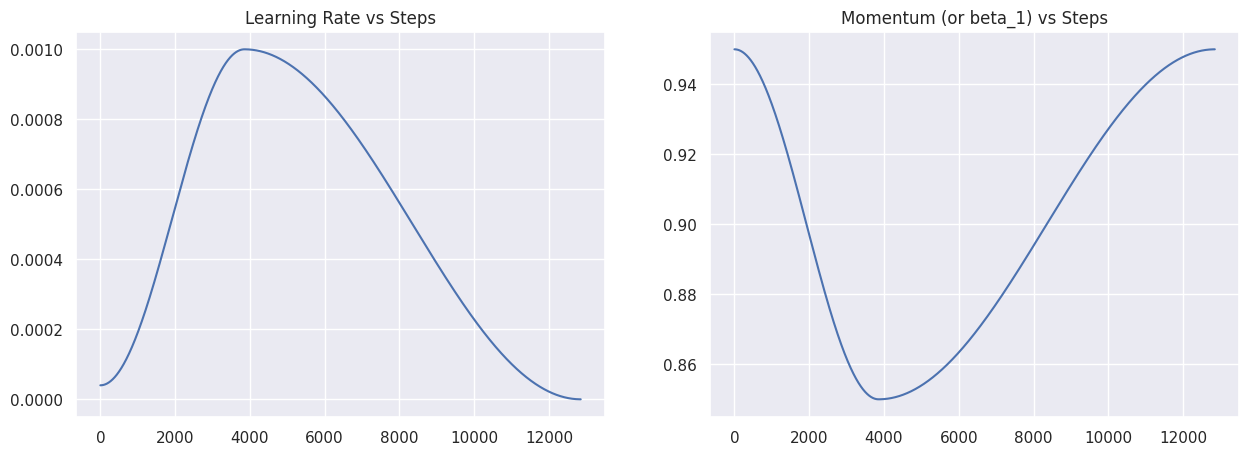

In [ ]:
sns.set_style("darkgrid", {"axes.grid":True})
onec.plot_lrs_moms()

### Read Model Checkpoint

At this stage, we have the option to save the trained model to disk for future use, or alternatively, we can load a pre-trained model from storage:

In [24]:
# Load pretrained model
!cp /content/drive/MyDrive/protein-reconstruction/models/model_beta.h5 .

In [ ]:
# We can also save the model in the last iteration
# model.save(ROOT_DIR+"models/beta.h5") # one may choose to store the final model

In [ ]:
# Save the current model
# !cp {TRAINING_DIR}/training/{config.model_name}.h5 {ROOT_DIR}models/test.h5

In [25]:
# put correct filename
#model_filename = TRAINING_DIR+"/training/"+config.model_name+".h5" # The current model
model_filename = "model_beta.h5" # The pretrained model

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename, compile=False, custom_objects={"BlurLayer": BlurLayer})

# Show the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 cnn (Functional)            [(None, 4, 4),               2015735   ['input_3[0][0]',             
                              None]                       4          'input_4[0][0]']             
                                                                                                  
 distance (Lambda)           (None,)                      0         ['cnn[0][1]',             

## Analysis

### Performance Plot - True vs. Predicted

We now proceed to utilize the trained model to make inferences on the training, validation, and test datasets:

In [26]:
cnn = model.layers[-2]

In [27]:
q_pred_train = cnn.predict(X[train_idx])[1]
q_pred_val = cnn.predict(X[val_idx])[1]
q_pred_test = cnn.predict(X[test_idx])[1]

52/52 [==============================] - 2s 45ms/step


After obtaining the predictions, we can compute the error metrics using the `d_q()` function to evaluate the model's performance:

In [28]:
#vgg s2s2 1/2
c1 = d_q(q_pred_train, matrix2quaternion(y[train_idx]))
c2 = d_q(q_pred_val, matrix2quaternion(y[val_idx]))
c3 = d_q(q_pred_test, matrix2quaternion(y[test_idx]))
np.median(c1), np.median(c2), np.median(c3), np.mean(c1), np.mean(c2), np.mean(c3)

(0.02290208068070726,
 0.05168726505682916,
 0.0505442427072207,
 0.023892768161175186,
 0.1852293596702932,
 0.1529550270192575)

In [ ]:
#https://docs.wandb.ai/guides/track/log
#run.summary["training_error_median"] = np.median(c1)
#run.summary["validation_error_median"] = np.median(c2)
#run.summary["testing_error_median"] = np.median(c3)
#run.summary["training_error_mean"] = np.mean(c1)
#run.summary["validation_error_mean"] = np.mean(c2)
#run.summary["testing_error_mean"] = np.mean(c3)
#run

In [ ]:
#config.model_name, run.dir

In [ ]:
#model.save(os.path.join(run.dir, "beta/training/"+config.model_name+".h5"))

In [ ]:
#run.finish()

#### Visulization

In this step, we will define a `d_p()` function to calculate the distances for randomly drawn pairs from the testing set and compare these calculated distances with the ground truth distances to assess accuracy:

In [29]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=256)

In [30]:
yy = y[test_idx]
XX = X[test_idx]

idx1 = list(np.random.choice(np.arange(1650), size=5000))
idx2 = list(np.random.choice(np.arange(1650), size=5000))

q1_true = matrix2quaternion([yy[i] for i in idx1])
q2_true = matrix2quaternion([yy[i] for i in idx2])

p1 = [XX[i] for i in idx1]
p2 = [XX[i] for i in idx2]

aa = d_p(p1, p2)

dP_values = aa[0].squeeze().T
dQ_values = d_q(q1_true, q2_true).numpy()

20/20 [==============================] - 25s 563ms/step


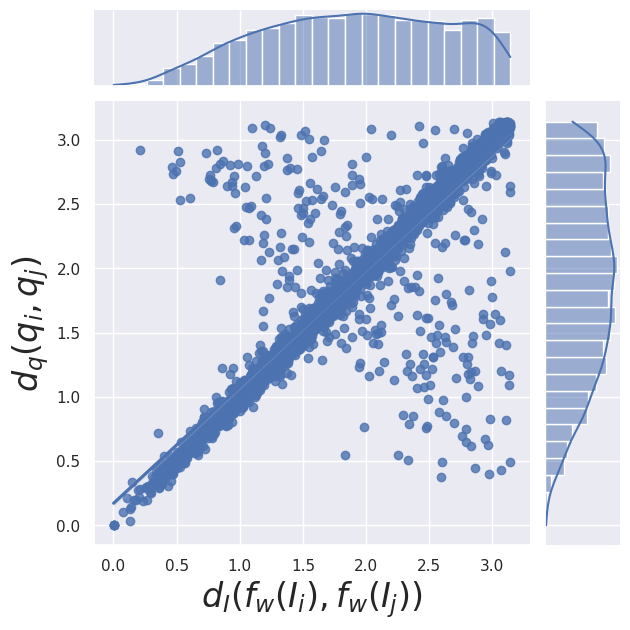

In [31]:
sns.set_style("darkgrid", {"axes.grid":True})
cc = sns.jointplot(x=dP_values, y=dQ_values, kind='reg')
cc.set_axis_labels('$d_I(f_w(I_i), f_w(I_j))$', '$d_q(q_i,q_j)$', fontsize=24);

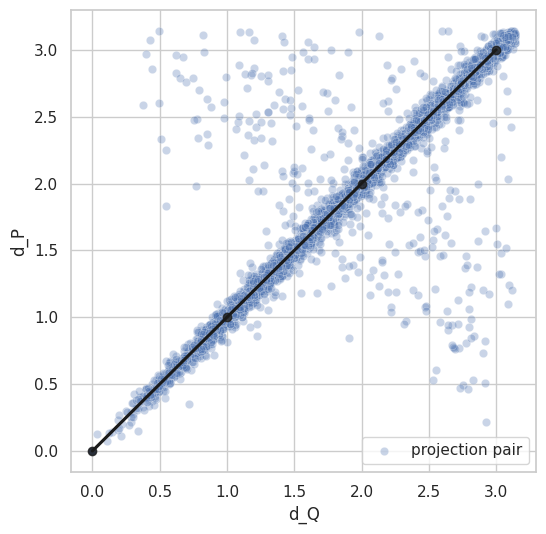

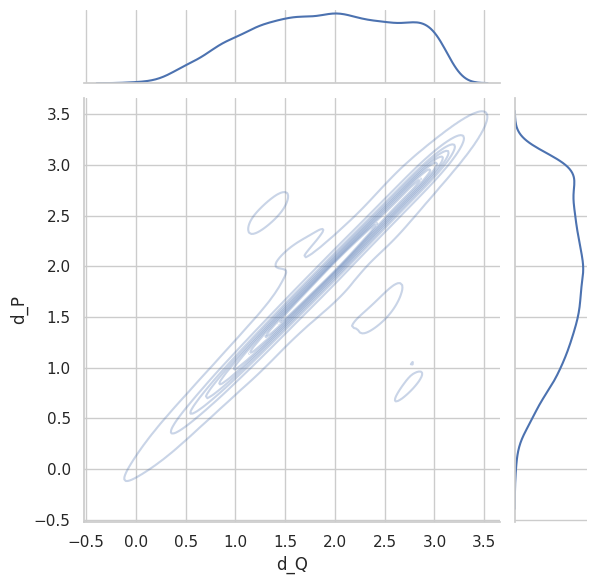

Variance = 0.3030578601307419
Min. angle recovery loss possible = 0.09182569777370692
MAE:  0.09843932


In [32]:
plot_dP_dQ(dP_values, dQ_values)

#### Uncertainty quantification with Matrix `A`

To quantify uncertainty in our model predictions, we establish several metrics as follows:

In [33]:
from cryoem.uncertainty import max_dispersion_coeff, sum_bingham_dispersion_coeff, first_eig_gap, wigner_log_likelihood_measure

In [34]:
def compute_threshold(A, uncertainty_metric_fn=first_eig_gap, quantile=0.75):
  stats = uncertainty_metric_fn(A)
  return np.quantile(stats, quantile)

In [35]:
def _scatter(ax, x, y, title, color='tab:red', marker=".", size =4, rasterized=False):
    ax.scatter(x, y, color=color, s=size, marker=marker, label=title, rasterized=rasterized)
    return

def _create_scatter_plot(thresh, thresh_label, lls, errors, labels, xlabel, ylim=None, legend=True, ylabel=True):
    fig, ax = plt.subplots()
    fig.set_size_inches(10,6)
    ax.axvline(thresh, c='k', ls='--', lw=0.75, label=thresh_label)
    colors = ['tab:orange','grey']
    markers = ['.', '+']
    for i, (ll, error, label) in enumerate(zip(lls, errors, labels)):
        _scatter(ax, ll, error, label, color=colors[i], size=1, marker=markers[i], rasterized=True)
    if legend:
        ax.legend(loc='upper left', markerscale=5.0, fontsize=14)
    ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)
    if ylabel:
        ax.set_ylabel('Error', fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    #ax.set_yscale('log')
    #ax.set_xscale('symlog')
    #ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    ax.set_ylim(ylim)
    return fig

We will now extract the metrics from matrix `A` and compile them into a `DataFrame` for structured analysis and reporting:

In [36]:
A_train = cnn.predict(X[train_idx])[0]
A_val = cnn.predict(X[val_idx])[0]
A_test = cnn.predict(X[test_idx])[0]

52/52 [==============================] - 2s 32ms/step


In [37]:
lls = [max_dispersion_coeff(A_test), max_dispersion_coeff(A_train)]
lls2 = [sum_bingham_dispersion_coeff(A_test), sum_bingham_dispersion_coeff(A_train)]
lls3 = [first_eig_gap(A_test), first_eig_gap(A_train)]
lls4 = [wigner_log_likelihood_measure(A_test), wigner_log_likelihood_measure(A_train)]
errors = [d_q(q_pred_test, matrix2quaternion(y[test_idx])), d_q(q_pred_train, matrix2quaternion(y[train_idx]))]
df = pd.DataFrame([errors[0].numpy(), lls[0], lls2[0], lls3[0], lls4[0]]).T
df

,0,1,2,3,4
0,0.117923,-78.044556,-838.567299,78.044556,-6.244517e+04
1,0.069874,-566.491577,-2660.916626,566.491577,-7.151986e+05
2,0.063348,-436.326660,-2094.089966,436.326660,-4.060166e+05
3,0.081885,-407.502472,-2059.990601,407.502472,-3.286016e+05
4,0.038152,-72.136810,-667.055115,72.136810,-3.610334e+04
...,...,...,...,...,...
1645,0.028849,-130.831970,-782.155975,130.831970,-4.526445e+04
1646,0.034798,-420.988159,-2182.261841,420.988159,-3.858468e+05
1647,0.045640,-790.635742,-3590.355835,790.635742,-1.368136e+06
1648,0.058696,-77.080551,-495.346146,77.080551,-1.694997e+04


In [38]:
np.quantile(errors[0].numpy(), 0.25), np.quantile(errors[0].numpy(), 0.5), np.quantile(errors[0].numpy(), 0.75)

(0.03341749544087856, 0.0505442427072207, 0.07561005003295083)

In [39]:
df.columns = ['error', 'max', 'trace', 'gap', 'likelihood']

In [40]:
mybins = pd.IntervalIndex.from_tuples([(0, np.quantile(errors[0].numpy(), 0.25)),
                    (np.quantile(errors[0].numpy(), 0.25), np.quantile(errors[0].numpy(), 0.5)),
                    (np.quantile(errors[0].numpy(), 0.5), np.quantile(errors[0].numpy(), 0.75)),
                    (np.quantile(errors[0].numpy(), 0.75), 3.14)])
df['testing error'] = pd.cut(df['error'], bins = mybins)
df['testing error'] = df['testing error'].apply(lambda x: x.right)
df

,error,max,trace,gap,likelihood,testing error
0,0.117923,-78.044556,-838.567299,78.044556,-6.244517e+04,3.140000
1,0.069874,-566.491577,-2660.916626,566.491577,-7.151986e+05,0.075610
2,0.063348,-436.326660,-2094.089966,436.326660,-4.060166e+05,0.075610
3,0.081885,-407.502472,-2059.990601,407.502472,-3.286016e+05,3.140000
4,0.038152,-72.136810,-667.055115,72.136810,-3.610334e+04,0.050544
...,...,...,...,...,...,...
1645,0.028849,-130.831970,-782.155975,130.831970,-4.526445e+04,0.033417
1646,0.034798,-420.988159,-2182.261841,420.988159,-3.858468e+05,0.050544
1647,0.045640,-790.635742,-3590.355835,790.635742,-1.368136e+06,0.050544
1648,0.058696,-77.080551,-495.346146,77.080551,-1.694997e+04,0.075610


In [41]:
df.describe()

,error,max,trace,gap,likelihood
count,1650.000000,1650.000000,1650.000000,1650.000000,1.650000e+03
mean,0.152955,-268.903480,-1475.307570,268.903480,-2.297100e+05
std,0.520343,174.939651,797.704716,174.939651,2.447972e+05
min,0.002985,-987.227905,-4472.310303,1.002670,-1.810108e+06
25%,0.033417,-375.507622,-1985.983841,130.482502,-3.072286e+05
50%,0.050544,-247.041641,-1393.670044,247.041641,-1.567250e+05
75%,0.075610,-130.482502,-848.633713,375.507622,-6.298812e+04
max,3.140281,-1.002670,-60.697845,987.227905,-2.294703e+02


Next, we'll create a scatter plot to visualize the relationship between the computed statistics and the testing error:

In [42]:
sns.set()

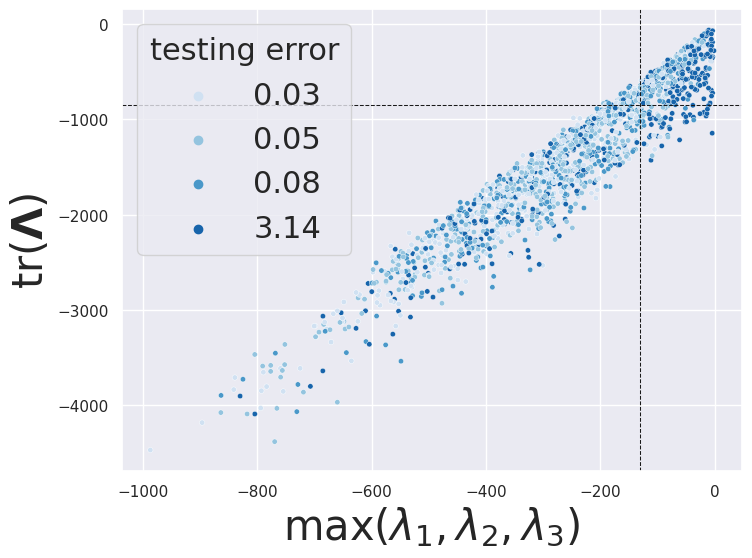

In [43]:
# Create scatter plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data=df, x="max", y="trace", hue='testing error', palette='Blues', s=15)

# Get the current legend
ax.legend(loc=0, fontsize=22)
legend = ax.legend_
legend.set_title("testing error")
legend.get_title().set_fontsize(22)
# Modify the legend labels in-place
for text in legend.get_texts():  # Skip the first label, which is the legend title ('bins')
    value = float(text.get_text())
    new_label = "{:.2f}".format(value)  # Format with 2 decimal places
    text.set_text(new_label)


ax.axvline(df.describe().loc['75%', 'max'], c='k', ls='--', lw=0.75, label='x threshold: \n q=' + '{:.2F}'.format(0.75))
ax.axhline(df.describe().loc['75%', 'trace'], c='k', ls='--', lw=0.75, label='y threshold: \n q=' + '{:.2F}'.format(0.75))
ax.set_xlabel('$\max(\lambda_1, \lambda_2, \lambda_3)$', fontsize=30)
ax.set_ylabel('tr($\mathbf{\Lambda})$', fontsize=30)
# Show the plot
plt.show()

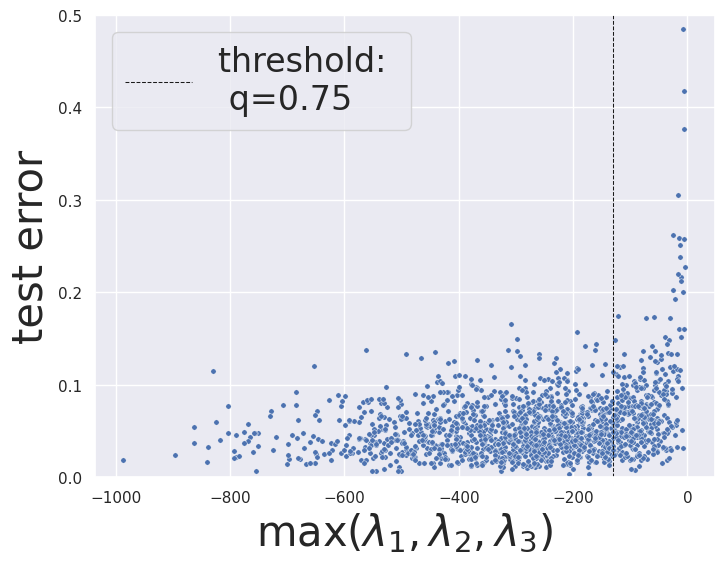

In [44]:
# Create scatter plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data=df, x="max", y="error", s=15)

ax.axvline(df.describe().loc['75%', 'max'], c='k', ls='--', lw=0.75, label='threshold: \n q=' + '{:.2F}'.format(0.75))
ax.set_xlabel('$\max(\lambda_1, \lambda_2, \lambda_3)$', fontsize=30)
ax.set_ylabel('test error', fontsize=30)
ax.set_ylim([0, 0.5])
ax.legend(fontsize=24)
# Show the plot
plt.show()

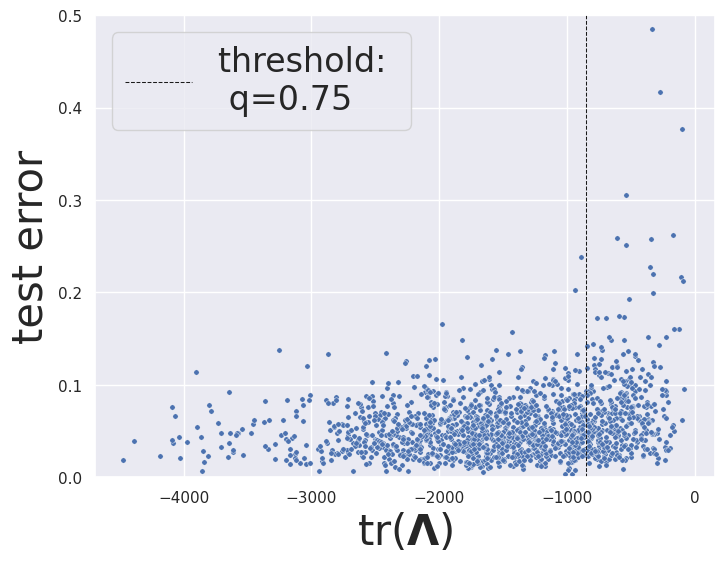

In [45]:
# Create scatter plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data=df, x="trace", y="error", s=15)

ax.axvline(df.describe().loc['75%', 'trace'], c='k', ls='--', lw=0.75, label='threshold: \n q=' + '{:.2F}'.format(0.75))
ax.set_xlabel('tr($\mathbf{\Lambda})$', fontsize=30)
ax.set_ylabel('test error', fontsize=30)
ax.set_ylim([0, 0.5])
ax.legend(fontsize=24)
# Show the plot
plt.show()

### Filter the particles and write out star file

We can construct three distinct `DataFrames` by applying three different filtering schemes based on the Q3 quantile:

In [46]:
filtered_df = df[(df['max'] < df.describe().loc['75%', 'max']) & (df['trace'] < df.describe().loc['75%', 'trace'])]
filtered_df.describe()

,error,max,trace,gap,likelihood
count,1168.000000,1168.000000,1168.000000,1168.000000,1.168000e+03
mean,0.052962,-346.098392,-1828.877830,346.098392,-3.071308e+05
std,0.093927,148.307506,666.876046,148.307506,2.522055e+05
min,0.002985,-987.227905,-4472.310303,130.666275,-1.810108e+06
25%,0.030884,-432.940292,-2204.887253,235.480309,-3.877978e+05
50%,0.045740,-311.542511,-1714.848297,311.542511,-2.263028e+05
75%,0.065651,-235.480309,-1325.820721,432.940292,-1.416480e+05
max,3.137654,-130.666275,-851.742950,987.227905,-5.225241e+04


In [47]:
filtered_df2 = df[(df['max'] < df.describe().loc['75%', 'max'])]
filtered_df2.describe()

,error,max,trace,gap,likelihood
count,1237.000000,1237.000000,1237.000000,1237.000000,1.237000e+03
mean,0.053149,-335.244805,-1769.985644,335.244805,-2.929538e+05
std,0.091552,150.915604,691.950464,150.915604,2.519283e+05
min,0.002985,-987.227905,-4472.310303,130.547836,-1.810108e+06
25%,0.030890,-423.255280,-2166.225281,218.473770,-3.773602e+05
50%,0.046021,-301.319397,-1669.123932,301.319397,-2.157043e+05
75%,0.065932,-218.473770,-1252.916321,423.255280,-1.232746e+05
max,3.137654,-130.547836,-650.531509,987.227905,-3.577572e+04


In [48]:
filtered_df3 = df[(df['trace'] < df.describe().loc['75%', 'trace'])]
filtered_df3.describe()

,error,max,trace,gap,likelihood
count,1237.000000,1237.000000,1237.000000,1237.000000,1.237000e+03
mean,0.076026,-331.535840,-1784.122054,331.535840,-2.960895e+05
std,0.270709,156.295930,674.351564,156.295930,2.493962e+05
min,0.002985,-987.227905,-4472.310303,4.061798,-1.810108e+06
25%,0.031310,-423.255280,-2166.225281,218.473770,-3.773602e+05
50%,0.046624,-301.319397,-1669.123932,301.319397,-2.162030e+05
75%,0.066898,-218.473770,-1257.429688,423.255280,-1.300029e+05
max,3.137654,-4.061798,-850.803833,987.227905,-5.225241e+04


We can produce STAR files that encapsulate both the true and predicted orientations for further analysis and comparison:

In [55]:
qo = quaternion2euler(q_pred_test).numpy()

projections_filename = DATASET_PATH+"beta_ctf_q2.star"
s = Starfile.load(projections_filename)
df = s.df
df['_rlnImageName'] = df['_rlnImageName'].str.replace('ctf_q2', 'noisy')
df2 = df.iloc[test_idx].copy()
df2['_rlnAngleRot'] = (qo[:,0]/(2*np.pi)*360.0 +360)%360.0
df2['_rlnAngleTilt'] = qo[:,1]/(2*np.pi)*360.0
df2['_rlnAnglePsi'] = (qo[:,2]/(2*np.pi)*360.0 +360)%360.0
df2['_rlnAngleRot'] = df2['_rlnAngleRot'].astype(str)
df2['_rlnAngleTilt'] = df2['_rlnAngleTilt'].astype(str)
df2['_rlnAnglePsi'] = df2['_rlnAnglePsi'].astype(str)

In [56]:
df3 = df.iloc[test_idx].copy()
df3.head(50)

,_rlnAnglePsi,_rlnAngleRot,_rlnAngleTilt,_rlnImageName,_rlnOriginX,_rlnOriginY,_rlnDefocusU,_rlnDefocusV,_rlnDefocusAngle
8,153.629600,49.113350,11.867888,000009@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
12,277.359800,94.028210,68.261024,000013@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
14,151.396060,157.411850,44.730470,000015@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
17,192.817630,97.958466,53.420303,000018@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
19,127.930880,96.078510,81.353035,000020@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
23,219.982900,72.319160,60.057950,000024@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
26,219.047150,105.275520,78.097530,000027@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
29,337.951700,57.533073,62.453620,000030@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
30,181.984860,34.646885,55.753315,000031@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
31,187.634280,141.880300,71.912384,000032@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000


In [57]:
df2.head(50)

,_rlnAnglePsi,_rlnAngleRot,_rlnAngleTilt,_rlnImageName,_rlnOriginX,_rlnOriginY,_rlnDefocusU,_rlnDefocusV,_rlnDefocusAngle
8,134.04907,65.2735,6.7368255,000009@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
12,275.64526,98.15616,67.06526,000013@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
14,155.06885,154.47314,47.192223,000015@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
17,189.43451,103.57205,54.59639,000018@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
19,128.46582,97.56769,82.786476,000020@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
23,221.06995,71.710236,56.870384,000024@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
26,218.8436,104.77969,75.67161,000027@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
29,338.32162,57.54123,60.621216,000030@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
30,180.58856,35.256653,56.195026,000031@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
31,187.2691,142.46542,69.07985,000032@beta_noisy.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000


To ensure compatibility with `cryoSPARC`, we will append additional columns to the STAR files as follows:

In [58]:
df2['_rlnAmplitudeContrast'] = 0.150000
df2['_rlnSphericalAberration'] = 2.000000
df2['_rlnVoltage'] = 200.000000
df2['_rlnAmplitudeContrast'] = df2['_rlnAmplitudeContrast'].astype(str)
df2['_rlnSphericalAberration'] = df2['_rlnSphericalAberration'].astype(str)
df2['_rlnVoltage'] = df2['_rlnVoltage'].astype(str)
s2 = Starfile(df2.columns, df2)
s2.write('beta_new2.star')

In [59]:
df3['_rlnAmplitudeContrast'] = 0.150000
df3['_rlnSphericalAberration'] = 2.000000
df3['_rlnVoltage'] = 200.000000
df3['_rlnAmplitudeContrast'] = df3['_rlnAmplitudeContrast'].astype(str)
df3['_rlnSphericalAberration'] = df3['_rlnSphericalAberration'].astype(str)
df3['_rlnVoltage'] = df3['_rlnVoltage'].astype(str)
s3 = Starfile(df3.columns, df3)
s3.write('beta_true2.star')

> Be sure to tailor the optical settings to match the specifications of your dataset.

We will also create filtered STAR files that exclude outliers based on the three predefined filtering schemes:

In [60]:
df10 = df2.iloc[filtered_df.index.values].copy()

In [61]:
df10['_rlnAmplitudeContrast'] = 0.150000
df10['_rlnSphericalAberration'] = 2.000000
df10['_rlnVoltage'] = 200.000000
df10['_rlnAmplitudeContrast'] = df10['_rlnAmplitudeContrast'].astype(str)
df10['_rlnSphericalAberration'] = df10['_rlnSphericalAberration'].astype(str)
df10['_rlnVoltage'] = df10['_rlnVoltage'].astype(str)
s10 = Starfile(df10.columns, df10)
s10.write('beta_sel_mt.star')

In [62]:
df11 = df2.iloc[filtered_df2.index.values].copy()

In [63]:
df11['_rlnAmplitudeContrast'] = 0.150000
df11['_rlnSphericalAberration'] = 2.000000
df11['_rlnVoltage'] = 200.000000
df11['_rlnAmplitudeContrast'] = df11['_rlnAmplitudeContrast'].astype(str)
df11['_rlnSphericalAberration'] = df11['_rlnSphericalAberration'].astype(str)
df11['_rlnVoltage'] = df11['_rlnVoltage'].astype(str)
s11 = Starfile(df11.columns, df11)
s11.write('beta_sel_m.star')

In [64]:
df12 = df2.iloc[filtered_df3.index.values].copy()

In [65]:
df12['_rlnAmplitudeContrast'] = 0.150000
df12['_rlnSphericalAberration'] = 2.000000
df12['_rlnVoltage'] = 200.000000
df12['_rlnAmplitudeContrast'] = df12['_rlnAmplitudeContrast'].astype(str)
df12['_rlnSphericalAberration'] = df12['_rlnSphericalAberration'].astype(str)
df12['_rlnVoltage'] = df12['_rlnVoltage'].astype(str)
s12 = Starfile(df12.columns, df12)
s12.write('beta_sel_t.star')

This additional analysis will delve into the discrepancies between the true orientations (`df3`) and the predicted orientations (`df2`):

In [66]:
df4 = df2.loc[:,'_rlnAnglePsi':'_rlnAngleTilt'].astype(float) - df3.loc[:,'_rlnAnglePsi':'_rlnAngleTilt'].astype(float)

In [67]:
a1 = df4['_rlnAnglePsi']%360
a2 = df4['_rlnAngleRot']%360
a3 = df4['_rlnAngleTilt']%180

b1 = a1.values
b2 = a2.values
b3 = a3.values

In [68]:
c1 = np.where(b1 <180, b1, 360-b1)
c2 = np.where(b2 <180, b2, 360-b2)
c3 = np.where(b3 <90, b3, 180-b3)

df4['_rlnAnglePsi_a'] = c1
df4['_rlnAngleRot_a'] = c2
df4['_rlnAngleTilt_a'] = c3

In [69]:
df4

,_rlnAnglePsi,_rlnAngleRot,_rlnAngleTilt,_rlnAnglePsi_a,_rlnAngleRot_a,_rlnAngleTilt_a
8,-19.580530,16.160150,-5.131063,19.580530,16.160150,5.131063
12,-1.714540,4.127950,-1.195764,1.714540,4.127950,1.195764
14,3.672790,-2.938710,2.461753,3.672790,2.938710,2.461753
17,-3.383120,5.613584,1.176087,3.383120,5.613584,1.176087
19,0.534940,1.489180,1.433441,0.534940,1.489180,1.433441
...,...,...,...,...,...,...
4990,0.516350,-1.573470,-0.951130,0.516350,1.573470,0.951130
4995,1.631838,-2.555298,1.290253,1.631838,2.555298,1.290253
4996,0.994410,-2.568715,1.168866,0.994410,2.568715,1.168866
4998,1.407070,-1.538740,-2.856970,1.407070,1.538740,2.856970


In [70]:
df4.describe()

,_rlnAnglePsi,_rlnAngleRot,_rlnAngleTilt,_rlnAnglePsi_a,_rlnAngleRot_a,_rlnAngleTilt_a
count,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000
mean,0.262903,1.727538,-0.921703,5.635389,6.672195,1.807817
std,35.561446,24.576685,3.285912,22.778567,22.809423,2.894320
min,-356.517590,-174.052110,-55.112458,0.001340,0.000820,0.000920
25%,-1.452133,-2.137116,-1.926787,0.744938,0.969021,0.601489
50%,0.054210,0.049240,-0.644598,1.550860,2.138615,1.277094
75%,1.585289,2.145522,0.510480,3.020266,4.019906,2.329936
max,359.074757,273.097160,7.371982,179.869860,179.936020,55.112458
